In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/")))

from src.python.helpers import (
    load_empirical_rt_data, 
    join_and_fill_missings,
    inspect_robustness_noise,
    inspect_robustness_bootstrap,
    inspect_robustness_lopo,
)
from src.python.settings import summary_meta_diffusion, probability_meta_diffusion
from src.python.training import setup_network
from src.python.visualization import plot_model_posteriors, plot_noise_robustness

import bayesflow as bf
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Application to empirical data

## Load in data

In [2]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(
    parent_folder, "data\\03_levy_flight_application\\data_rts\\color"
)
lexical_folder = os.path.join(
    parent_folder, "data\\03_levy_flight_application\\data_rts\\lexical"
)

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(
    color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True
)

## Load in trained network

In [3]:
summary_net, probability_net, amortizer = setup_network(
    summary_net_settings=summary_meta_diffusion,
    inference_net_settings=probability_meta_diffusion,
    loss_fun=partial(bf.losses.log_loss, label_smoothing=None)
)

checkpoint_path = "checkpoints/finetune"
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    checkpoint_path=checkpoint_path
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Loaded loss history from checkpoints/finetune\history_50.pkl.
INFO:root:Networks loaded from checkpoints/finetune\ckpt-50


## Predict

In [4]:
labels_verbose = [
    "Basic diffusion model",
    "Basic Lévy flight model",
    "Full diffusion model",
    "Full Lévy flight model",
]

labels = ["$\mathcal{M}_1$", "$\mathcal{M}_2$", "$\mathcal{M}_3$", "$\mathcal{M}_4$"]

In [5]:
preds = np.array(probability_net.posterior_probs(summary_net(empirical_data)))
preds

array([[0.00007515, 0.01163833, 0.7806216 , 0.20766494]], dtype=float32)

### Get PMP & BF tables

In [28]:
# Get posterior model probabilities
pmp_table = pd.DataFrame(preds, index=["$\text{PMP}$"], columns=labels)
pmp_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$\text{PMP}$,0.000075,0.01,0.78,0.21


In [29]:
# Get Bayes Factors
bfs = []

for model in range(4):
    for model_prob in preds:
        model_bfs = model_prob / preds[0][model]
        bfs.append(model_bfs)

bf_table_all = pd.DataFrame(bfs, index=labels_verbose, columns=labels_verbose)
bf_table_all

,Basic diffusion model,Basic Lévy flight model,Full diffusion model,Full Lévy flight model
Basic diffusion model,1.000000,133.069229,10379.400391,2794.453857
Basic Lévy flight model,0.007515,1.000000,78.000000,21.000000
Full diffusion model,0.000096,0.012821,1.000000,0.269231
Full Lévy flight model,0.000358,0.047619,3.714286,1.000000


In [30]:
# Select Bayes Factors for publication
winning_model_index = np.argmax(preds)

bfs_contra = pd.DataFrame(
    bf_table_all.iloc[winning_model_index, :].values.reshape(1, 4),
    index=["$\text{BF}_{" + "j" + f"{winning_model_index+1}" + "}$"],
    columns=labels,
)
bfs_contra

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$\text{BF}_{j3}$,0.000096,0.012821,1.0,0.269231


In [31]:
bfs_pro = pd.DataFrame(
    bf_table_all.iloc[:, winning_model_index].values.reshape(1, 4),
    index=["$\text{BF}_{" +  f"{winning_model_index+1}" + "j}$"],
    columns=labels,
)
bfs_pro

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$\text{BF}_{3j}$,10379.400391,78.0,1.0,3.714286


In [32]:
# Create table for publication
for m in range(4):
    if bfs_contra.iloc[0, m] < 0.01:  # only resort to scientific notation when needed
        bfs_contra.iloc[0, m] = f"{bfs_contra.iloc[0, m]:.2e}"
    else:
        bfs_contra.iloc[0, m] = bfs_contra.iloc[0, m].round(2)

    if bfs_pro.iloc[0, m] > 100:  # only resort to scientific notation when needed
        bfs_pro.iloc[0, m] = f"{bfs_pro.iloc[0, m]:.2e}"
    else:
        bfs_pro.iloc[0, m] = bfs_pro.iloc[0, m].round(2)

    if pmp_table.iloc[0, m] < 0.01:
        pmp_table.iloc[0, m] = f"{pmp_table.iloc[0, m]:.2e}"
    else:
        pmp_table.iloc[0, m] = pmp_table.iloc[0, m].round(2)

bfs_contra.iloc[0, winning_model_index] = "*"  # replace 1s of preferred model
bfs_pro.iloc[0, winning_model_index] = "*"  # replace 1s of preferred model
results_table = pd.concat([bfs_contra, bfs_pro, pmp_table])
results_table

,$\mathcal{M}_1$,$\mathcal{M}_2$,$\mathcal{M}_3$,$\mathcal{M}_4$
$\text{BF}_{j3}$,9.63e-05,0.01,*,0.27
$\text{BF}_{3j}$,1.04e+04,78.0,*,3.71
$\text{PMP}$,7.51e-05,1.00e-02,0.78,0.21


In [33]:
print(results_table.style.to_latex(position="h", position_float="centering", hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{llllr}
\toprule
 & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
$	ext{BF}_{j3}$ & 9.63e-05 & 0.010000 & * & 0.270000 \\
$	ext{BF}_{3j}$ & 1.04e+04 & 78.000000 & * & 3.710000 \\
$	ext{PMP}$ & 7.51e-05 & 1.00e-02 & 0.780000 & 0.210000 \\
\bottomrule
\end{tabular}
\end{table}



# Robustness checks

## Results under data perturbations

In [12]:
bootstrapped_trials = inspect_robustness_bootstrap(
    empirical_data, probability_net, summary_net, level="trials", n_bootstrap=100
)
bootstrapped_participants = inspect_robustness_bootstrap(
    empirical_data, probability_net, summary_net, level="participants", n_bootstrap=100
)
leave_one_participant_out = inspect_robustness_lopo(
    empirical_data, probability_net, summary_net
)

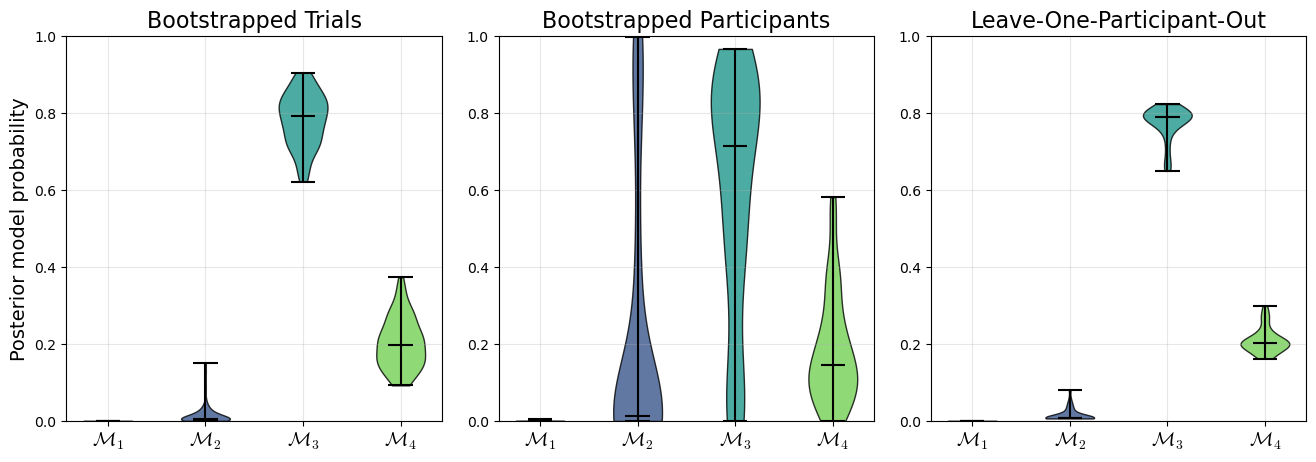

In [13]:
fig, axarr = plt.subplots(1, 3, figsize=(16, 5))
plt.subplots_adjust(wspace=0.15)

plot_model_posteriors(
    bootstrapped_trials, labels, title="Bootstrapped Trials", ax=axarr[0]
)
plot_model_posteriors(
    bootstrapped_participants,
    labels,
    ylabel=False,
    title="Bootstrapped Participants",
    ax=axarr[1],
)
plot_model_posteriors(
    leave_one_participant_out,
    labels,
    ylabel=False,
    title="Leave-One-Participant-Out",
    ax=axarr[2],
)

plt.savefig("levy_perturbation_robustness.pdf", dpi=300, bbox_inches="tight")

## Results under additional noise

In [14]:
added_noise_percentages = np.arange(0, 0.51, 0.01)
mean_noise_proportion_list, mean_probs, mean_sds = inspect_robustness_noise(
    added_noise_percentages, empirical_data, probability_net, summary_net, n_runs=100
)

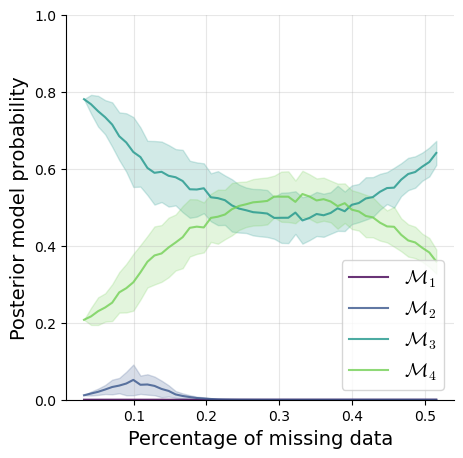

In [15]:
plot_noise_robustness(
    mean_noise_proportion_list, mean_probs, mean_sds, labels, legend_loc="lower right", save=True
)